In [1]:
import numpy as np
import matplotlib.pyplot as plt
from copy import copy
import utils as ut

# Mean field simulations

In [25]:
### Dot equations for the three variables to be passed to nsolve (in utils.py)

def mean_field_T_dot(var, pars):
    T, P, S = var
    return T * ( pars.beta * P * max(0,1-S) - pars.gamma )

def mean_field_S_dot(var, pars):
    T, P, S = var
    if S >= 1: return 0
    return pars.alpha * T

def mean_field_P_dot(var, pars):
    T, P, S = var
    return - P * ( pars.lambd * pars.beta * max(0,(1-S)) * T + pars.mu )


### Constants 

def t_star_MHC_approx(pars):
    r = pars.beta * pars.P0 - pars.gamma
    return np.log( r/pars.lambd/pars.beta/pars.n * np.log(pars.beta*pars.P0/pars.gamma) ) / r

def t_star_S_approx(pars):
    r = pars.beta * pars.P0 - pars.gamma
    return np.log(r**2/pars.alpha/pars.beta/pars.P0/pars.n) / r

def adim_var(pars):
    return pars.alpha / pars.beta / pars.lambd * np.log(pars.beta*pars.P0/pars.gamma)

In [26]:
# Building the container of parameters with default values
pars = ut.TT_params(beta=1, gamma=0.05, lambd=0.0001, P0=1.0, mu=0.01, alpha=None)

# Initial conditions of mean field T, P and S 
init_vars = [1.0, pars.P0, 0.0]

# Dot equations for T, P and S
dot_eqs = [mean_field_T_dot, mean_field_P_dot, mean_field_S_dot]

# Integration paraemters
t_steps, dt, traj_steps = 5000, 0.01, 10

In [33]:
# Integrating for the default parameters and specific values of alpha
alphas = [2e-6, 1e-3]
T_trajs_alpha, P_trajs_alpha, S_trajs_alpha = [], [], []
for a in alphas:
    pars.alpha = a
    trajs = np.array(ut.nsolve(init_vars, dot_eqs, pars, t_steps, dt, traj_steps))
    T_trajs_alpha.append(trajs[:,0])
    P_trajs_alpha.append(trajs[:,1])
    S_trajs_alpha.append(trajs[:,2])

# Integrating for the non-inhibition case alpha=0
pars.alpha = 0.0
trajs = np.array(ut.nsolve(init_vars, dot_eqs, pars, t_steps, dt, traj_steps))
T_trajs_no_inhib = trajs[:,0]
P_trajs_no_inhib = trajs[:,1]
S_trajs_no_inhib = trajs[:,2]

# Integrating for the non-antigen-depletion case, only inhibition
pars_no_depl = copy(pars) # Parameters not overwritten because they will be exported later
pars_no_depl.lambd = 0
pars_no_depl.mu = 0
pars_no_depl.alpha = alphas[-1]
trajs = np.array(ut.nsolve(init_vars, dot_eqs, pars_no_depl, t_steps, dt, traj_steps))
T_trajs_no_depl = trajs[:,0]
P_trajs_no_depl = trajs[:,1]
S_trajs_no_depl = trajs[:,2]

In [34]:
# The two values of alpha are chosen to be in the two different regimes
# The adimensional quantity will be much smaller/larger than 1

pars.alpha = alphas[0]
print(r'Adimensional quantity for alpha={} : {}'.format(pars.alpha, adim_var(pars)))
pars.alpha = alphas[1]
print('Adimensional quantity for alpha={} : {}'.format(pars.alpha, adim_var(pars)))

Adimensional quantity for alpha=2e-06 : 0.05991464547107981
Adimensional quantity for alpha=0.001 : 29.957322735539908


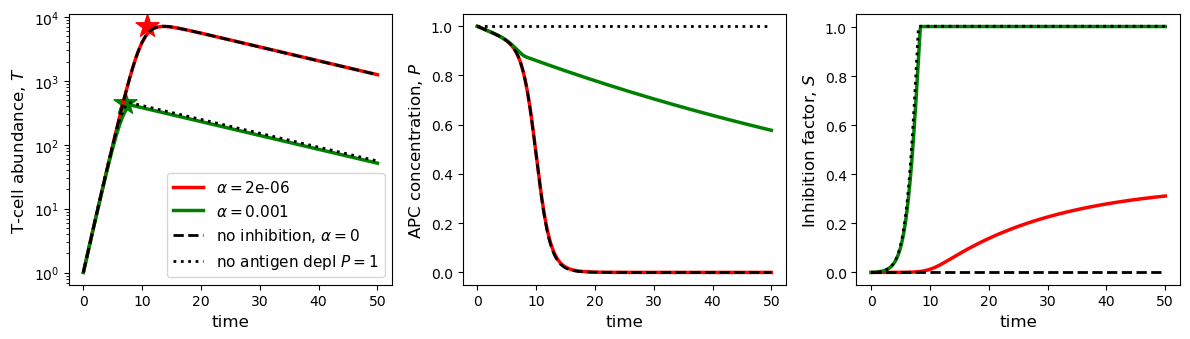

In [35]:
times = np.linspace(0, t_steps * dt, len(T_trajs_no_depl))
colors = ['r', 'g']

fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(12,3.5))

for ax in (ax1, ax2, ax3):
    ax.set_xlabel('time', fontsize=12)
    
ax1.set_ylabel('T-cell abundance, $T$', fontsize=12)
ax1.set_yscale('log')
for i, Ts in enumerate(T_trajs_alpha):
    ax1.plot(times, Ts, color=colors[i], lw=2.5, label=r'$\alpha=$%.g'%alphas[i])
ax1.plot(times, T_trajs_no_inhib, color='k', lw=2, ls='--', label=r'no inhibition, $\alpha=0$')
ax1.plot(times, T_trajs_no_depl, color='k', lw=2, ls=':', label=r'no antigen depl $P=1$')
ax1.legend(fontsize=11)

pars.alpha = 0
ax1.scatter([t_star_MHC_approx(pars)], [np.max(T_trajs_no_inhib)], s=300, c='r', marker='*')
ax1.scatter([t_star_S_approx(pars_no_depl)], [np.max(T_trajs_no_depl)], s=300, c='g', marker='*')


ax2.set_ylabel('APC concentration, $P$', fontsize=12)
for i, Ps in enumerate(P_trajs_alpha):
    ax2.plot(times, Ps, color=colors[i], lw=2.5)
ax2.plot(times, P_trajs_no_inhib, color='k', lw=2, ls='--')
ax2.plot(times, P_trajs_no_depl, color='k', lw=2, ls=':')

ax3.set_ylabel('Inhibition factor, $S$', fontsize=12)
for i, Ss in enumerate(S_trajs_alpha):
    ax3.plot(times, Ss, color=colors[i], lw=2.5)
ax3.plot(times, S_trajs_no_inhib, color='k', lw=2, ls='--')
ax3.plot(times, S_trajs_no_depl, color='k', lw=2, ls=':')

plt.tight_layout()

name = 'mean_field_dyn'
plt.savefig('plots/'+name+'.svg', dpi=200, facecolor='w')

pars.alpha = None # Alpha changes every time and is shwon in the plot legend
pars.print_on_file('plots/'+name+'_pars.tsv')